# Kaggle Competition: ASHRAE - Great Energy Predictor III
São feitos investimentos significativos para melhorar a eficiência de construções e reduzir seus custos e suas emissões. A questão é: as melhorias estão funcionando? Com o pagamento por desempenho, o proprietário do edifício paga com base na diferença entre o consumo real de energia e o que eles teriam usado sem nenhuma reforma. Os últimos valores têm que vir de um modelo. Os métodos atuais de estimativa são fragmentados e não escalam bem. Alguns assumem um tipo específico de medidor ou não trabalham com diferentes tipos de construção.

Nesta competição, terão de ser desenvolvidos modelos precisos do uso de energia de edifícios medidos nas seguintes áreas: medidores de água resfriada, elétrica, água quente e vapor. Os dados são provenientes de mais de 1.000 edifícios, medidos por hora, em um período de três anos (62 milhões de linhas). Com melhores estimativas desses investimentos em economia de energia, os investidores em larga escala e as instituições financeiras estarão mais inclinadas a investir nessa área, permitindo assim o progresso de edificações eficientes.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Load
Foram fornecidos 5 arquivos pela competição, os arquivos de treino e teste com Id’s das construções, quando as medições foram feitas e informações sobre o tipo de energia que é consumida. Os arquivos de dados climáticos para os períodos das medições de treino e teste e as informações sobre as construções. Fiz o tratamento dos dados em um notebook anterior para economizar memória, onde realizei a minificação dos dados utilizando técnicas difundidas no Kaggle e a junção de todos os dataframes em dados de treino (aproximadamente 20 milhões de linhas) e teste (aproximadamente 42 milhões de linhas), como saída foram gerados os dois arquivos .pkl que usarei neste notebook.

In [2]:
dftrain = pd.read_pickle('train.pkl')
dftest = pd.read_pickle('test.pkl')
print ('Train: %s , Test %s' % (dftrain.shape, dftest.shape) )

Train: (20216100, 16) , Test (41697600, 16)


São 16 colunas com informações sobre o momento da medição, sobre o valor da medição, informações sobre as construções, o seu uso e sobre o clima no momento da medição.

In [5]:
dftrain.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


A maioria das colunas está no formato numérico. Apenas as colunas do momento da medição e do uso primário da construção estão em formatos diferentes. No notebook de modelagem eu transformo estas colunas para serem usadas de melhores formas.

In [3]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             object
meter_reading         float64
site_id               int8
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float64
cloud_coverage        float16
dew_temperature       float64
precip_depth_1_hr     float16
sea_level_pressure    float64
wind_direction        float16
wind_speed            float64
dtypes: float16(5), float64(5), int16(1), int32(1), int8(2), object(2)
memory usage: 1.4+ GB


In [4]:
print ('Train shape:', dftrain.shape)
print ('Test shape:', dftest.shape)

Train shape: (20216100, 16)
Test shape: (41697600, 16)


Vamos ver quantos dados estão faltando em cada coluna para os dados de treino e de teste.

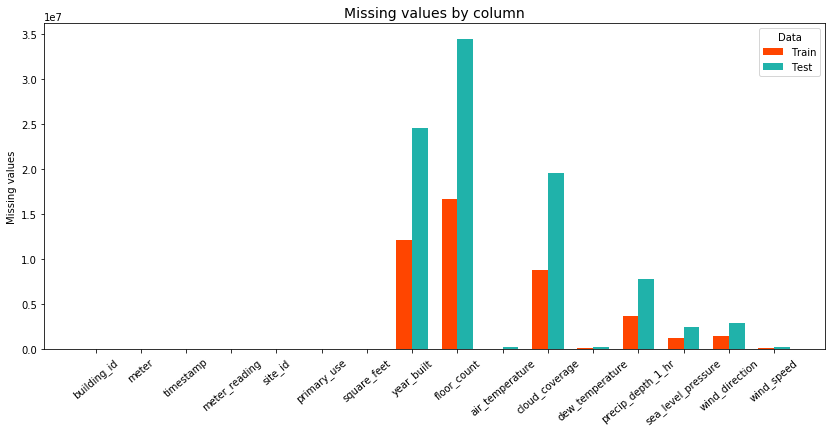

In [363]:
ind = np.arange(len(dftrain.columns))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6))
plt.title('Missing values by column', fontsize=14)

axes.bar(dftrain.columns, dftrain.isnull().sum(), width, color='orangered')
axes.bar(ind+width, dftest.isnull().sum(), width, color='lightseagreen')

plt.ylabel('Missing values')
plt.xticks(rotation=40)
axes.set_xticks(ind + width / 2)
plt.legend(title='Data',loc='upper right', labels=['Train', 'Test'])
plt.show()

Parece que tanto os dados de treino e de teste tem a quantidade de dados faltantes por coluna equivalentes. A coluna de número de andares é a que tem a maior quantidade de dados faltantes, seguida pelo ano construído e pela quantidade de nuvens.

In [6]:
dftrain.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8088455.0,3506933.0,2.011944e+07,11390735.0,2.011596e+07,16467077.0,1.898443e+07,18767052.0,2.007242e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03,7.992232e+00,1.077830e+05,NaN,NaN,1.598795e+01,NaN,7.747429e+00,NaN,1.016085e+03,NaN,3.377525e+00
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,NaN,0.0,1.094729e+01,0.0,1.017867e+01,NaN,7.060539e+00,NaN,2.265694e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1900.0,1.0,-2.890000e+01,0.0,-3.500000e+01,-1.0,9.682000e+02,0.0,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1951.0,1.0,8.600000e+00,0.0,0.000000e+00,0.0,1.011600e+03,70.0,2.100000e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1969.0,3.0,1.670000e+01,0.0,8.900000e+00,0.0,1.016000e+03,180.0,3.100000e+00
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1993.0,6.0,2.410000e+01,4.0,1.610000e+01,0.0,1.020500e+03,280.0,4.600000e+00
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2017.0,26.0,4.720000e+01,9.0,2.610000e+01,343.0,1.045500e+03,360.0,1.900000e+01


Olhando para as distribuições. Podemos ver que a medição (que está em log) tem uma quantidade extremamente grande de valores próximos do 0. Já o tipo de energia consumida, é maior no tipo 1 (Segundo a descrição da competição {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}).

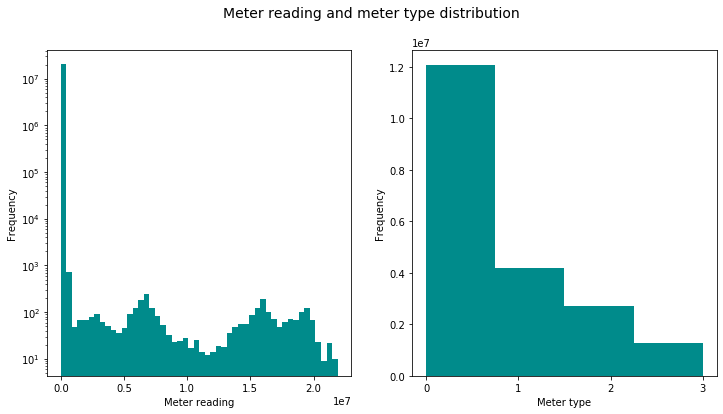

In [393]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
fig.suptitle('Meter reading and meter type distribution', fontsize=14)
dftrain.meter_reading.plot.hist(color='darkcyan', bins=50, ax=axes[0],log=True)
dftrain.meter.plot.hist(color='darkcyan', bins=4, ax=axes[1])
axes[0].set(xlabel='Meter reading')
axes[1].set(xlabel='Meter type')
axes[1].set_xticks(np.arange(0, 4, step=1))
plt.show()

Olhando a distribuição de todas as variáveis.

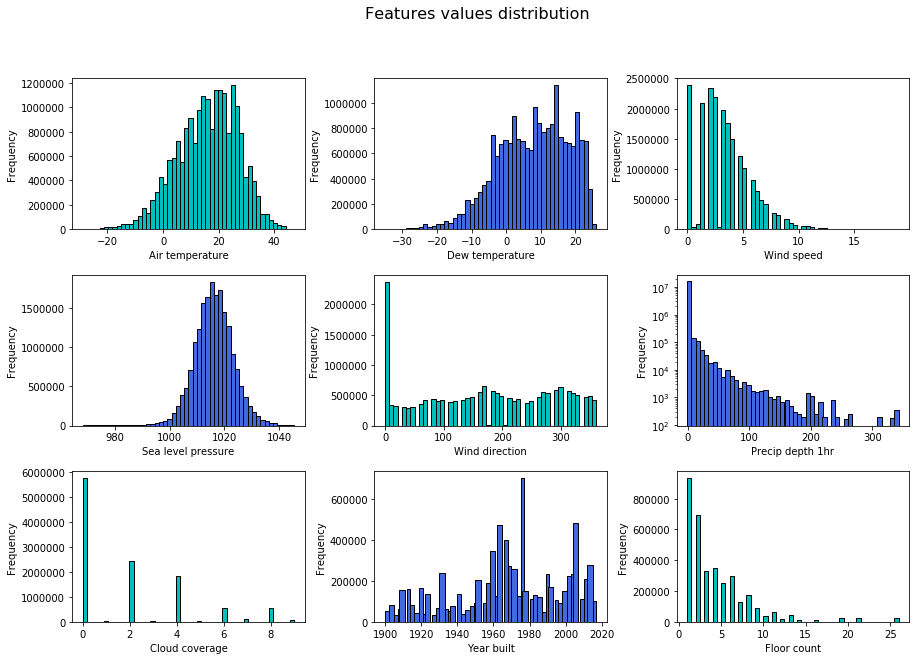

In [345]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=3, nrows=3)
fig.suptitle('Features values distribution', fontsize=16)

dftrain.air_temperature.plot.hist(edgecolor='black',color='c', bins=50, ax=axes[0,0])
axes[0,0].set(xlabel='Air temperature')

dftrain.dew_temperature.plot.hist(edgecolor='black',color='royalblue', bins=50, ax=axes[0,1])
axes[0,1].set(xlabel='Dew temperature')

dftrain.wind_speed.plot.hist(edgecolor='black',color='c', bins=50, ax=axes[0,2])
axes[0,2].set(xlabel='Wind speed')

dftrain.sea_level_pressure.plot.hist(edgecolor='black',color='royalblue', bins=50, ax=axes[1,0])
axes[1,0].set(xlabel='Sea level pressure')

dftrain.wind_direction.plot.hist(edgecolor='black',color='c', bins=50, ax=axes[1,1])
axes[1,1].set(xlabel='Wind direction')

dftrain.precip_depth_1_hr.plot.hist(edgecolor='black',color='royalblue', bins=50, ax=axes[1,2],log=True)
axes[1,2].set(xlabel='Precip depth 1hr')

dftrain.cloud_coverage.plot.hist(edgecolor='black',color='c', bins=50, ax=axes[2,0])
axes[2,0].set(xlabel='Cloud coverage')

dftrain.year_built.plot.hist(edgecolor='black',color='royalblue', bins=50, ax=axes[2,1])
axes[2,1].set(xlabel='Year built')

dftrain.floor_count.plot.hist(edgecolor='black',color='c', bins=50, ax=axes[2,2])
axes[2,2].set(xlabel='Floor count')

plt.subplots_adjust(wspace=0.3,hspace=0.3)
plt.show()

O que da para perceber é que a temperatura do ar e a pressão no nível do mar se aproximas de distribuições normais, com um pequeno indício de calda para a esquerda. Na distribuição da temperatura de orvalho isso fica mais evidente. Percebemos também que a quantidade de valores da profundidade de precipitação é muito maior próximo de 0. Há mais construções analisadas que foram construídas na década de 60-70 e nos anos 2000. As construções em maioria tem 1 andar.

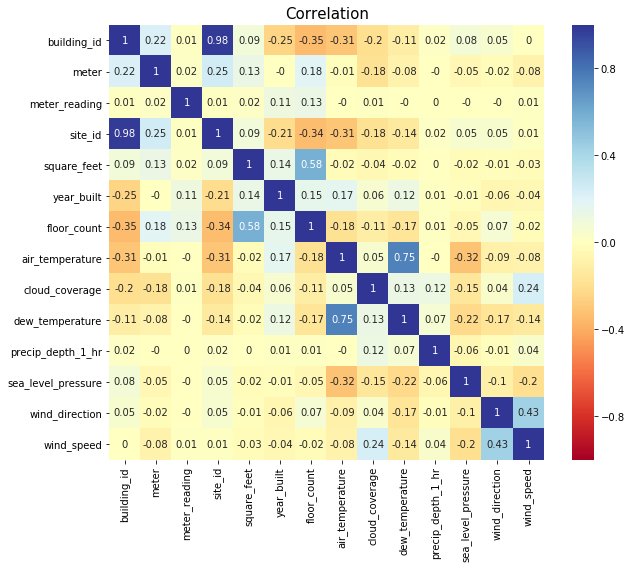

In [43]:
temp = dftrain
corrmat = round(temp.corr(method='pearson'),2)
plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, vmax=1.0, vmin=-1.0, square=True, annot=True, cmap='RdYlBu')
plt.title('Correlation', fontsize=15)
plt.show()

Observando a matriz de correlação, percebemos que não há um grande problema de multicolinearidade. Algumas colunas como temperatura do ar e temperatura de orvalho tem uma correlação que parece grande. Também a coluna de contagem de andares e tamanho de área parecem ter uma correlação. Vamos investigar isso melhor.

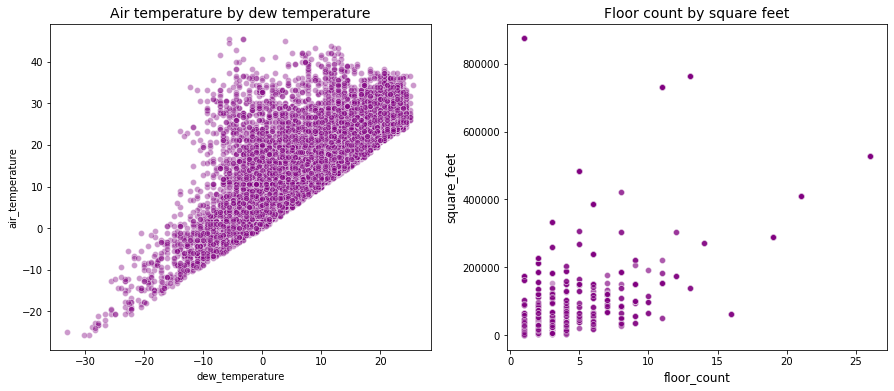

In [439]:
fig, axes = plt.subplots(figsize=(15, 6), ncols=2, nrows=1)

sns.scatterplot(x='dew_temperature', y='air_temperature', data=dftrain.sample(10000), alpha=0.4, color="purple", ax=axes[0])
axes[0].set_title('Air temperature by dew temperature', fontsize=14)
plt.xlabel('dew_temperature', fontsize=12)
plt.ylabel('air_temperature', fontsize=12)
sns.scatterplot(x='floor_count', y='square_feet', data=dftrain.sample(10000), alpha=0.4, color="purple", ax=axes[1])
axes[1].set_title('Floor count by square feet', fontsize=14)
plt.xlabel('floor_count', fontsize=12)
plt.ylabel('square_feet', fontsize=12)
plt.show()

A correlação entre a temperatura do ar e do ponto de orvalho parece bem evidente, como as duas features dizem praticamente a mesma coisa para o modelo, talvez seja interessante avaliar a exclusão de uma das duas posteriormente. Já a contagem de andares por área também tem uma correlação, porém não tão forte, elas possívelmente podem trazer informações diferentes para o modelo, sendo assim melhor deixá-las como features para o modelo.

Vou agrupar os dados por site_id, que possívelmente dizem respeito aos locais onde as construções se encontram e retirar a média dos valores.

In [104]:
site_id_means = dftrain.groupby(by='site_id').mean().reset_index()
site_id_means.head()

,site_id,building_id,meter,meter_reading,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,52.836768,0.156273,549.860779,86411.509331,1996.0,NaN,23.068507,3.048828,17.057623,1.389648,1017.960476,155.250,3.357777
1,1,128.682964,0.571286,149.531425,65927.879047,1961.0,6.921875,11.711534,0.084656,7.646251,NaN,1015.989928,195.625,3.966999
2,2,221.450340,0.912816,183.787944,107127.861840,1974.0,NaN,24.945502,1.958984,4.078375,0.157837,1011.677090,152.750,2.931917
3,3,427.253618,0.000000,125.919304,75146.897262,1962.0,NaN,15.525893,3.878906,8.130531,0.691895,1017.940303,185.000,3.911292
4,4,610.506526,0.000000,181.087793,95214.353837,1953.0,5.394531,15.233128,1.862305,9.902599,0.254883,1016.893515,207.375,3.845750


Olhando para a média de temperatura, podemos ver que ela é bem diferente para locais diferentes. Sendo o local 11 o mais frio e  o 2 o mais quente. A diferença de temperaturas é considerável, indicando que talvez as construções possam estar até em países diferentes.

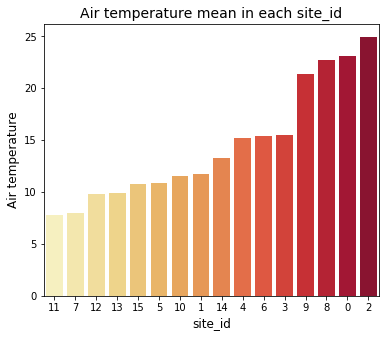

In [429]:
plt.figure(figsize=(6,5))
plt.title('Air temperature mean in each site_id', fontsize=14)
sns.barplot(x='site_id', y='air_temperature', 
            data = site_id_means,
            order = site_id_means.sort_values('air_temperature').site_id,
            palette = 'YlOrRd')
plt.xlabel('site_id', fontsize=12)
plt.ylabel('Air temperature', fontsize=12)
plt.show()

Agora vou fazer um gráfico para ver quanto consome de energia cada local.

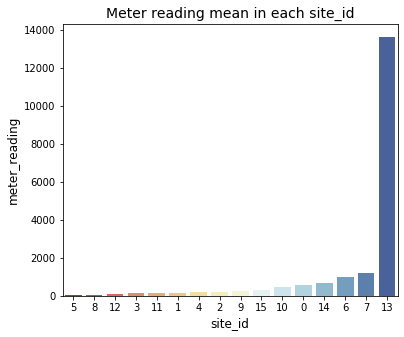

In [388]:
plt.figure(figsize=(6,5))
plt.title('Meter reading mean in each site_id', fontsize=14)
sns.barplot(x='site_id', y='meter_reading', 
            data = site_id_means,
            order = site_id_means.sort_values('meter_reading').site_id,
            palette = 'RdYlBu')
plt.xlabel('site_id', fontsize=12)
plt.ylabel('meter_reading', fontsize=12)
plt.show()

Parece que o local 13 consome uma quantidade de energia muito maior que os outros locais, vamos observar isso melhor. Seleciono apenas as construções do local 13 e agrupo por id da costrução, retirando a média das features.

In [412]:
dftrain[dftrain.site_id==13].groupby('building_id').mean().sort_values(by='meter_reading',ascending=False).head()

,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
building_id,,,,,,,,,,,,,
1099,1.000114,1.907446e+06,13.0,332884,NaN,NaN,9.879541,2.873047,3.401515,0.880859,1015.894753,188.000,4.197455
1197,1.000000,2.222224e+04,13.0,50552,NaN,NaN,9.879617,2.873047,3.401731,0.880371,1015.895371,188.000,4.197358
1168,1.009810,1.642528e+04,13.0,577101,NaN,NaN,9.795447,2.873047,3.344803,0.885742,1015.888965,188.375,4.206409
1159,1.005610,1.199166e+04,13.0,671507,NaN,NaN,9.816054,2.875000,3.354853,0.885742,1015.893209,188.125,4.203870
1148,1.004613,1.005890e+04,13.0,861524,NaN,NaN,9.997865,2.876953,3.509426,0.884766,1015.881502,187.625,4.194677


Olhando as colunas percebemos que o consumo de energia de uma construção específica de id 1099 tem um consumo muito maior do que todas as outras. Esta construção provavelmente tem algum erro na coleta de dados ou é um outlier. É necessária uma análise mais aprofundada posteriormente. Por momento vamos remover essa construção do nosso dataframe.

In [420]:
dftrain = dftrain[dftrain.building_id!=1099]

Agora vamos olhar novamente o gráfico de consumo por local.

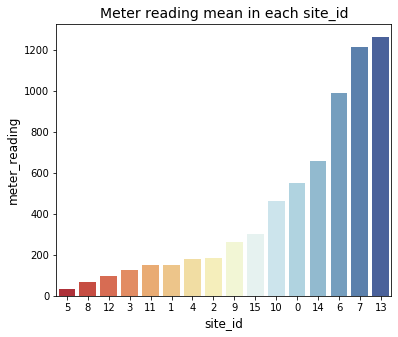

In [421]:
plt.figure(figsize=(6,5))
plt.title('Meter reading mean in each site_id', fontsize=14)
sns.barplot(x='site_id', y='meter_reading', 
            data = dftrain.groupby(by='site_id').mean().reset_index(),
            order = site_id_means.sort_values('meter_reading').site_id,
            palette = 'RdYlBu')
plt.xlabel('site_id', fontsize=12)
plt.ylabel('meter_reading', fontsize=12)
plt.show()

Agora sim parece que está tudo de uma forma mais natural. Vamos verificar agora o consumo por tipo de uso da construção.

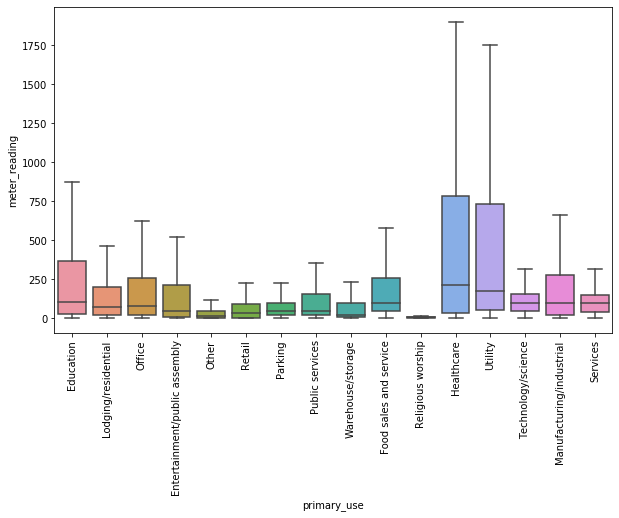

In [437]:
plt.figure(figsize=(10,6))
sns.boxplot(x='primary_use', y='meter_reading', data=dftrain, showfliers=False)
plt.xticks(rotation='vertical')
plt.show()

As construções que mais consomem energia são construções da área da saúde e utilidades. As que menos consomem são religiosas. Por hora terminamos a análise exploratória, vamos agora começar a realizar a [modelagem](https://github.com/rossinendrew/Portfolio/blob/master/ASHRAE-Solution.ipynb).